In [1]:
import math
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
from matplotlib import figure

In [2]:
def Q_air_heating(G, t1, t2):
  # G м3/ч 
  # Q_air_heating кВт
  return round(0.278 * 1.21 * 1.005 * G * (t1-t2) / 1000, 0)


def G_air_heating(Q, t1, t2):
  # G м3/ч 
  # Q_air_heating кВт
  return int ((Q * 1000) / (0.278 * 1.21 * 1.005 * (t1-t2)) if t1 != t2 else 0)


def plot_df(df: pd.DataFrame, y_column, xtick_step, title='заголовок', value='показатель'):

    plt.figure(figsize=(24, 12), dpi=80)

    fig, ax1 = plt.subplots(1, figsize=(24,12))
    
    ax1.plot(df.index, df[y_column])
    ax1.set_xticks(df.index[::xtick_step])
    ax1.set_xticklabels(df.index[::xtick_step], rotation=90)

    plt.title(f"{title}")
    plt.xlabel('День')
    plt.ylabel(value)
    plt.grid(True)
    plt.legend()
    plt.show()

    # plt.savefig(name_output)
    # plt.close(fig)

In [3]:
df = pd.read_csv('weather_historicat_prepared.csv', index_col=['Time'])

In [4]:
df

,day,month,year,hour,T
Time,,,,,
09.01.2025_09:00,9,1,2025,09:00,-1.3
09.01.2025_06:00,9,1,2025,06:00,0.7
09.01.2025_03:00,9,1,2025,03:00,1.0
09.01.2025_00:00,9,1,2025,00:00,1.9
08.01.2025_21:00,8,1,2025,21:00,2.7
...,...,...,...,...,...
01.02.2005_15:00,1,2,2005,15:00,-6.6
01.02.2005_12:00,1,2,2005,12:00,-7.1
01.02.2005_09:00,1,2,2005,09:00,-8.6


In [5]:
Q_it = 600

#считаем что расход воздуха через стойки постоянный 
# с разницей температур 7гр
t_hot_corridor_max = 35
t_cold_corridor_max = 28
delta_t = t_hot_corridor_max - t_cold_corridor_max
hours_step = 3

G_it = G_air_heating(Q_it, t_hot_corridor_max, t_cold_corridor_max)

fun_G_m3_h_intake = 19000
fun_number_intake = G_it // fun_G_m3_h_intake
fun_kW_e_intake = 6 

fun_G_m3_h_exhaust = 19000
fun_number_exhaust = G_it // fun_G_m3_h_exhaust
fun_kW_e_exhaust = 6 



cooling_temp_needs = []

df['G_intake'] = df['T'].map(lambda x: abs(G_air_heating(Q_it, t_hot_corridor_max, x)) if abs(x - t_hot_corridor_max) > delta_t else G_it)


df['G_recircle'] = G_it - df['G_intake']
df['G_full'] = G_it
df['G_%'] = 100* df['G_recircle'] / df['G_full'] 


for index, row in df.iterrows():
    cooling_temp_needs.append(round(t_hot_corridor_max - row['T'] - delta_t, 2)) if row['G_recircle'] == 0 else cooling_temp_needs.append(0)

df['cooling_needs_temp'] = cooling_temp_needs
df['cooling_kW*h'] = df['cooling_needs_temp'].map(lambda x: abs(hours_step * 0.31 * 1.21 * 1.005 * G_it * (x) / 1000))

df['cooling_kW*h_standart'] = abs((hours_step * 0.31 * 1.21 * 1.005 * G_it * 10 )/ 1000)


df['IT_consume_kW*h'] = hours_step * Q_it

df['fan_in_kW*h'] = hours_step * fun_number_intake * fun_kW_e_intake # поддерживаем расход равный расходу вентиляторов в стойках 
df['fan_out_kW*h'] = df['G_intake'].map(lambda x: (math.ceil(x / fun_G_m3_h_exhaust) * fun_kW_e_exhaust * hours_step))  # расход выбрасываемого воздуха равен приточному уличному

df['PUE_cooling'] = (df['fan_out_kW*h'] + df['fan_in_kW*h'] + df['cooling_kW*h'] + df['IT_consume_kW*h']) / df['IT_consume_kW*h']

In [6]:
sum(df['cooling_kW*h'])

486514.96538908227

In [7]:
(sum(df['fan_in_kW*h']) + sum(df['fan_out_kW*h'] )) / sum(df['cooling_kW*h_standart']) 

0.10987863033790123

In [8]:
sum(df['cooling_kW*h_standart']) 

193754362.74123698

In [9]:
df_freecooling_with_adiabat = df.copy()

In [10]:

df_freecooling_with_adiabat = df_freecooling_with_adiabat.loc[df_freecooling_with_adiabat['cooling_needs_temp'] < 0]
df_freecooling_with_adiabat['cooling_temp_adiabatic'] = -5
df_freecooling_with_adiabat['cooling_temp_result'] = df_freecooling_with_adiabat['cooling_needs_temp'] - df_freecooling_with_adiabat['cooling_temp_adiabatic'] 

df_freecooling_with_adiabat['cooling_kW*h'] = df_freecooling_with_adiabat['cooling_temp_result'].map(lambda x: abs(hours_step * 0.31 * 1.21 * 1.005 * G_it * (x) / 1000))

In [11]:
sum(df_freecooling_with_adiabat.loc[df_freecooling_with_adiabat['cooling_temp_result'] < 0]['cooling_kW*h'])

24659.802571734

In [12]:
df_freecooling_with_adiabat.loc[df_freecooling_with_adiabat['cooling_temp_result'] < 0]['cooling_kW*h'].describe()


count      51.000000
mean      483.525541
std       338.599297
min        28.674189
25%       157.708040
50%       516.135403
75%       673.843442
max      1376.361074
Name: cooling_kW*h, dtype: float64

In [31]:
df.loc[df['T'] == -10]['G_intake'].head()


Time
18.12.2024_15:00    39440
14.12.2023_15:00    39440
13.12.2023_06:00    39440
05.12.2022_03:00    39440
05.12.2022_00:00    39440
Name: G_intake, dtype: int64

In [14]:
df.PUE_cooling.describe()

count    67571.000000
mean         1.179038
std          0.058742
min          1.150000
25%          1.160000
50%          1.170000
75%          1.180000
max          2.831150
Name: PUE_cooling, dtype: float64

In [15]:
df.loc[df['PUE_cooling'] > 1.2]

,day,month,year,hour,T,G_intake,G_recircle,G_full,G_%,cooling_needs_temp,cooling_kW*h,cooling_kW*h_standart,IT_consume_kW*h,fan_in_kW*h,fan_out_kW*h,PUE_cooling
Time,,,,,,,,,,,,,,,,
28.09.2024_18:00,28,9,2024,18:00,22.3,139749,113797,253546,44.882191,0.0,0.0,2867.418904,1800,234,144,1.21
28.09.2024_15:00,28,9,2024,15:00,22.0,136524,117022,253546,46.154150,0.0,0.0,2867.418904,1800,234,144,1.21
26.09.2024_15:00,26,9,2024,15:00,22.6,143130,110416,253546,43.548705,0.0,0.0,2867.418904,1800,234,144,1.21
25.09.2024_15:00,25,9,2024,15:00,23.1,149144,104402,253546,41.176749,0.0,0.0,2867.418904,1800,234,144,1.21
21.09.2024_15:00,21,9,2024,15:00,21.9,135482,118064,253546,46.565120,0.0,0.0,2867.418904,1800,234,144,1.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18.05.2005_18:00,18,5,2005,18:00,22.9,146679,106867,253546,42.148959,0.0,0.0,2867.418904,1800,234,144,1.21
18.05.2005_15:00,18,5,2005,15:00,23.1,149144,104402,253546,41.176749,0.0,0.0,2867.418904,1800,234,144,1.21
18.05.2005_12:00,18,5,2005,12:00,23.0,147901,105645,253546,41.666995,0.0,0.0,2867.418904,1800,234,144,1.21


In [16]:
df.describe()

,day,month,year,T,G_intake,G_recircle,G_full,G_%,cooling_needs_temp,cooling_kW*h,cooling_kW*h_standart,IT_consume_kW*h,fan_in_kW*h,fan_out_kW*h,PUE_cooling
count,67571.000000,67571.000000,67571.000000,67571.000000,67571.000000,67571.000000,67571.0,67571.000000,67571.000000,67571.000000,6.757100e+04,67571.0,67571.0,67571.000000,67571.000000
mean,15.717305,6.460212,2014.527179,6.813700,76416.915703,177129.084297,253546.0,69.860729,-0.025110,7.200056,2.867419e+03,1800.0,234.0,81.068062,1.179038
std,8.807127,3.460609,5.335089,10.790217,41338.272617,41338.272617,0.0,16.304052,0.294726,84.510327,4.547507e-13,0.0,0.0,39.706473,0.058742
min,1.000000,1.000000,2005.000000,-30.500000,27096.000000,0.000000,253546.0,0.000000,-9.800000,0.000000,2.867419e+03,1800.0,234.0,36.000000,1.150000
25%,8.000000,3.000000,2010.000000,-0.700000,49714.000000,163454.000000,253546.0,64.467197,0.000000,0.000000,2.867419e+03,1800.0,234.0,54.000000,1.160000
50%,16.000000,6.000000,2014.000000,6.300000,61840.000000,191706.000000,253546.0,75.609948,0.000000,0.000000,2.867419e+03,1800.0,234.0,72.000000,1.170000
75%,23.000000,9.000000,2019.000000,15.300000,90092.000000,203832.000000,253546.0,80.392513,0.000000,0.000000,2.867419e+03,1800.0,234.0,90.000000,1.180000
max,31.000000,12.000000,2025.000000,37.800000,253546.000000,226450.000000,253546.0,89.313182,0.000000,2810.070526,2.867419e+03,1800.0,234.0,252.000000,2.831150


In [17]:
sum(df['cooling_kW*h'])

486514.96538908227

In [18]:
df.loc[df['cooling_kW*h'] > 0].count()

day                      866
month                    866
year                     866
hour                     866
T                        866
G_intake                 866
G_recircle               866
G_full                   866
G_%                      866
cooling_needs_temp       866
cooling_kW*h             866
cooling_kW*h_standart    866
IT_consume_kW*h          866
fan_in_kW*h              866
fan_out_kW*h             866
PUE_cooling              866
dtype: int64

In [19]:
df.loc[df['PUE_cooling'] > 1.2].count()

day                      5757
month                    5757
year                     5757
hour                     5757
T                        5757
G_intake                 5757
G_recircle               5757
G_full                   5757
G_%                      5757
cooling_needs_temp       5757
cooling_kW*h             5757
cooling_kW*h_standart    5757
IT_consume_kW*h          5757
fan_in_kW*h              5757
fan_out_kW*h             5757
PUE_cooling              5757
dtype: int64

In [20]:
sum(df['cooling_kW*h']) 

486514.96538908227

C:\Users\MID\AppData\Local\Temp\ipykernel_28804\74431229.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1920x960 with 0 Axes>

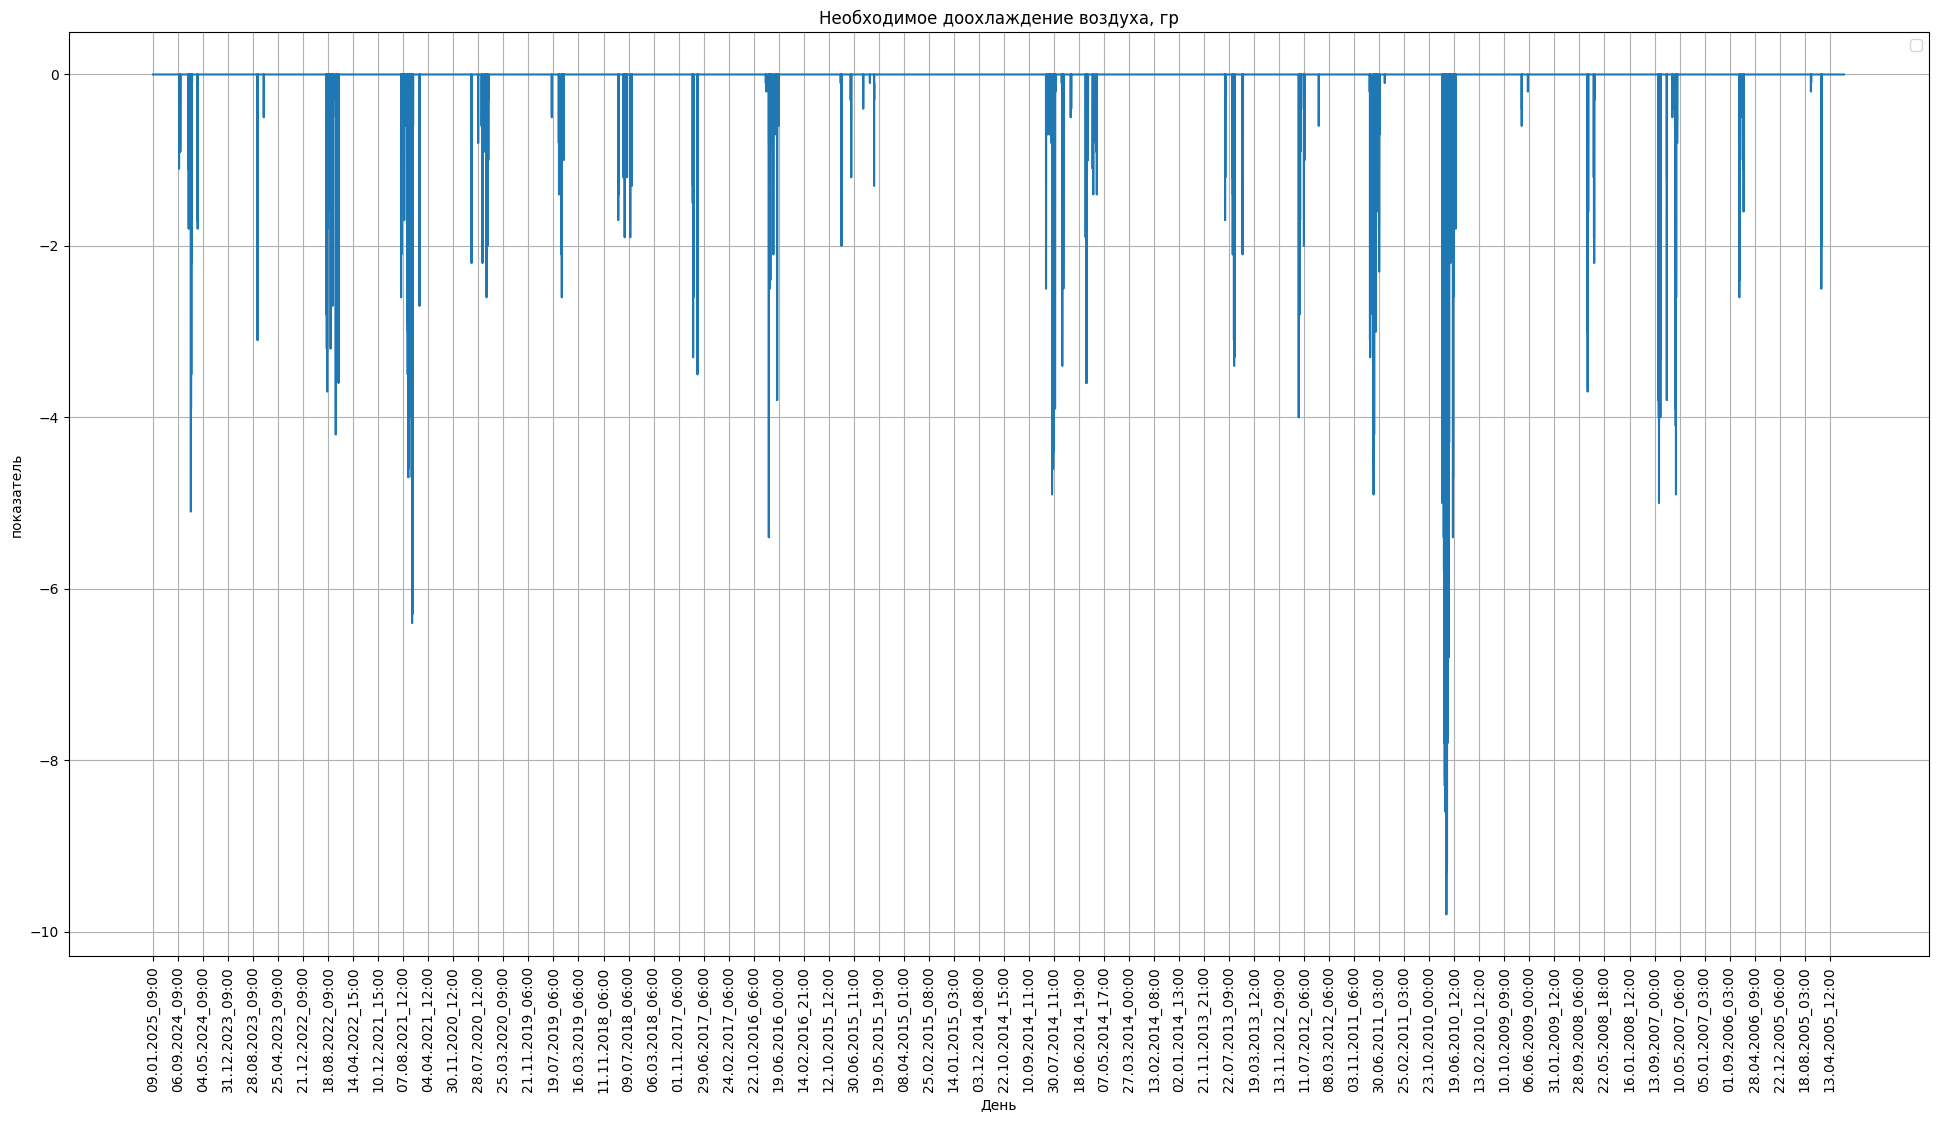

In [21]:
plot_df(df, 'cooling_needs_temp', 1000, 'Необходимое доохлаждение воздуха, гр')

C:\Users\MID\AppData\Local\Temp\ipykernel_28804\74431229.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1920x960 with 0 Axes>

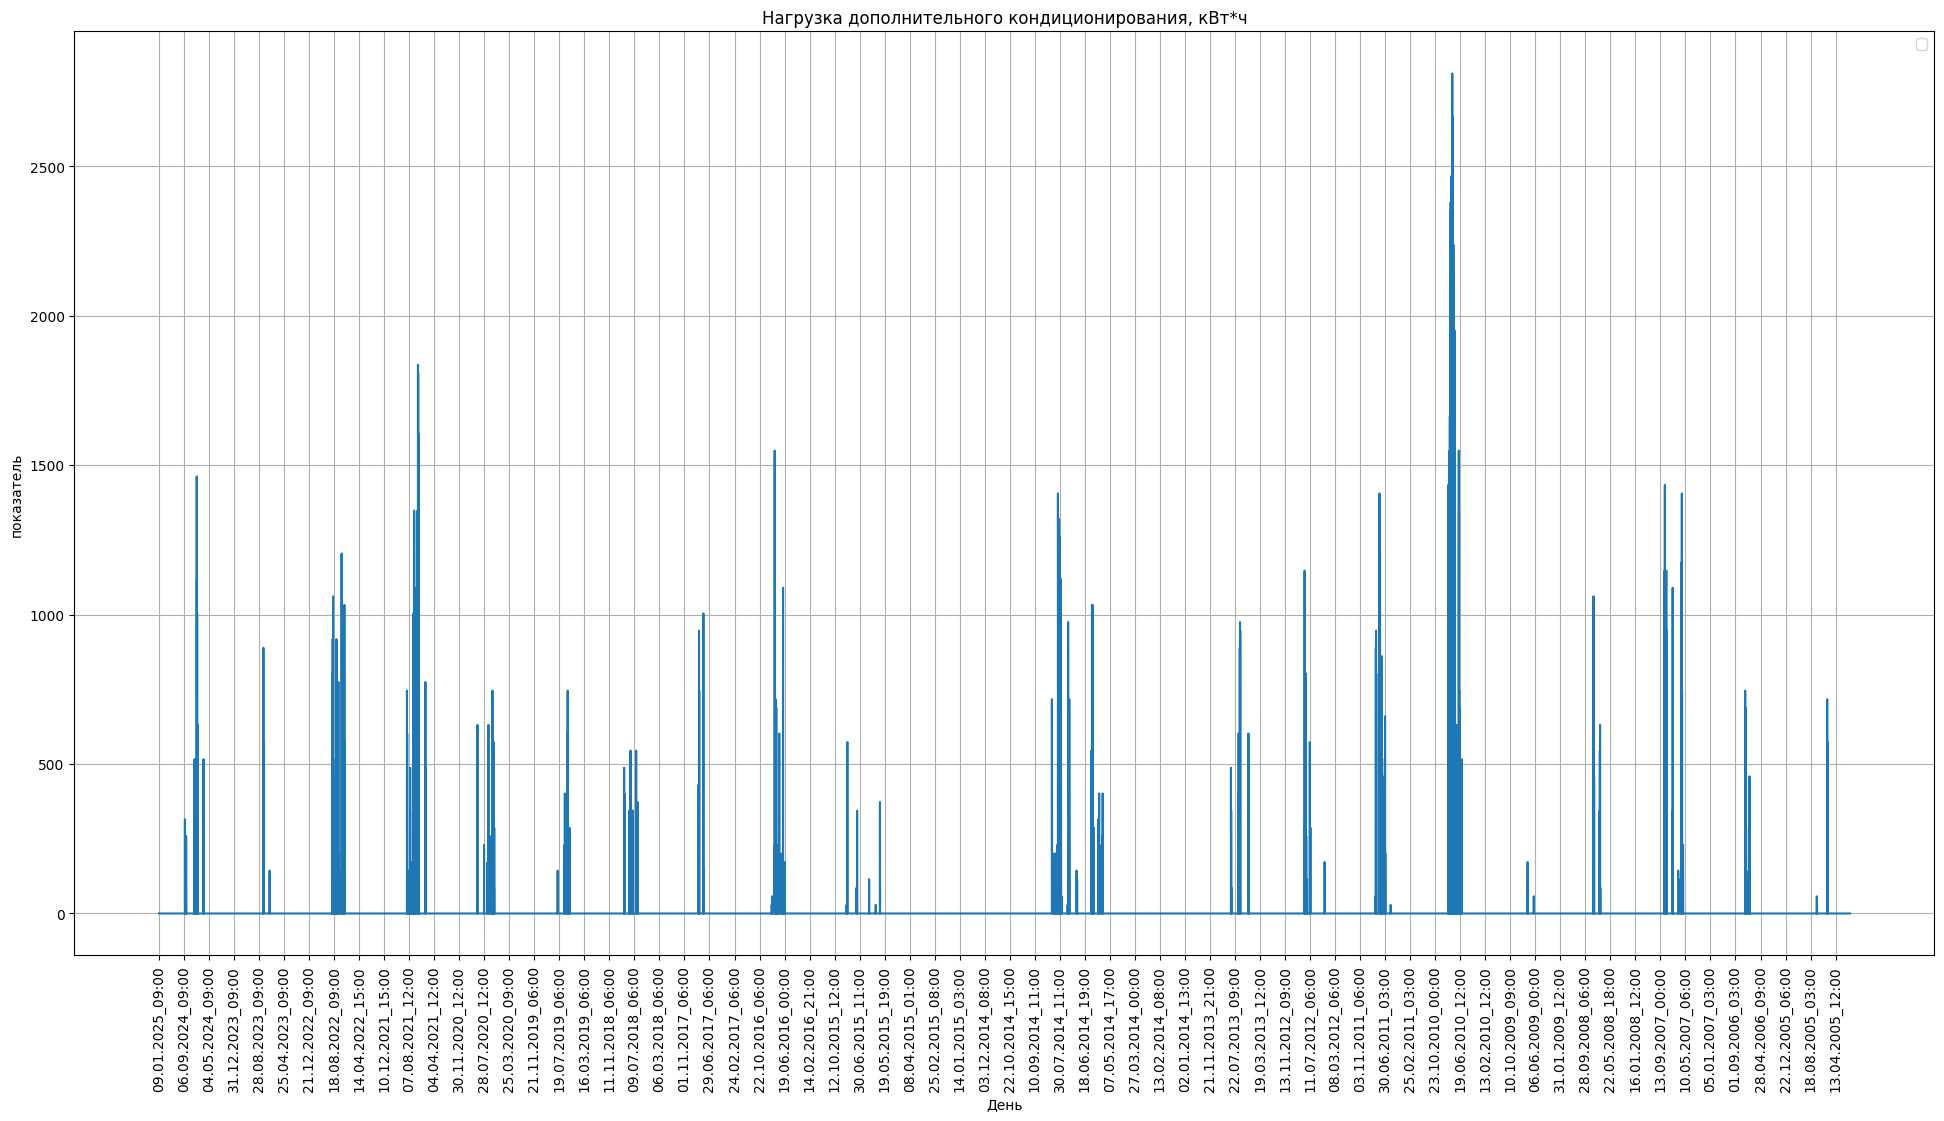

In [22]:
plot_df(df, 'cooling_kW*h', 1000,  'Нагрузка дополнительного кондиционирования, кВт*ч')

C:\Users\MID\AppData\Local\Temp\ipykernel_28804\74431229.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1920x960 with 0 Axes>

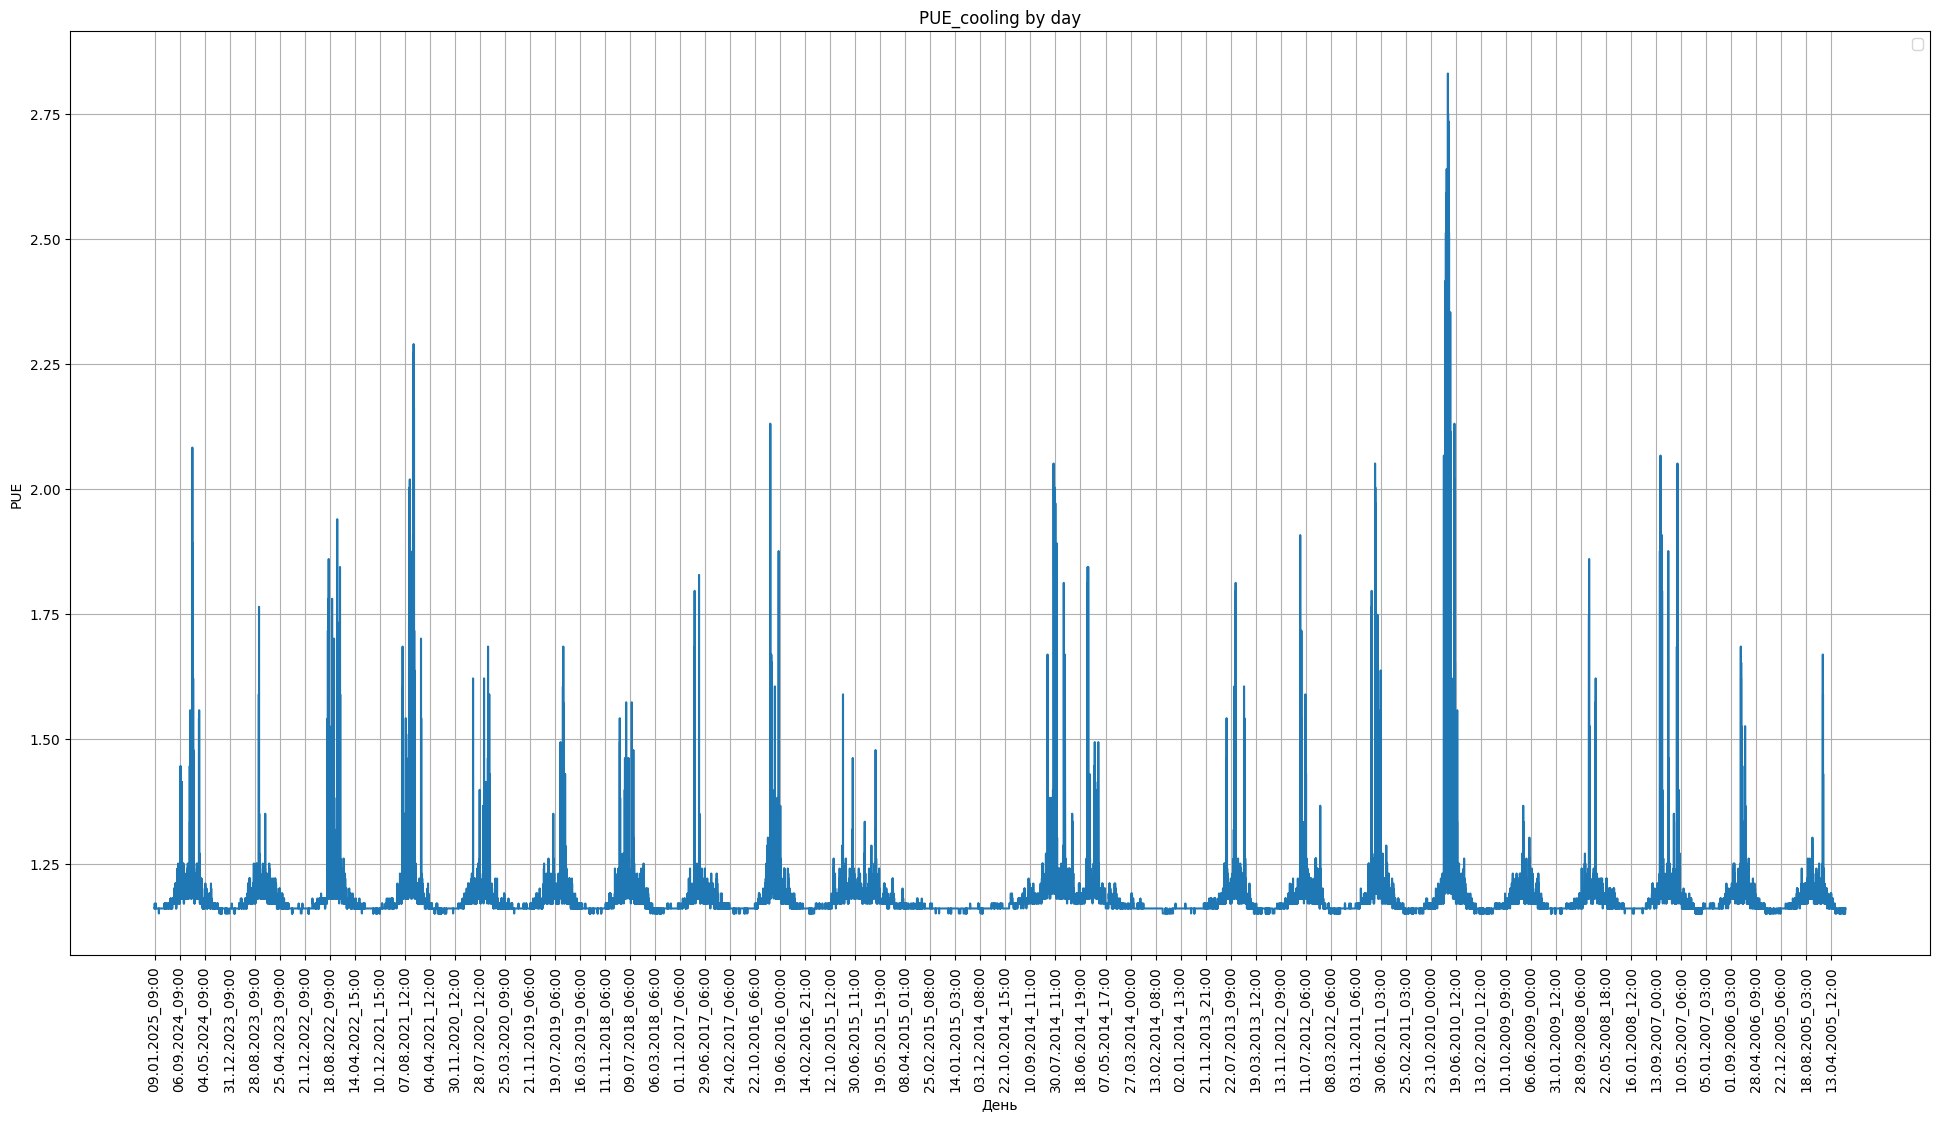

In [23]:
plot_df(df,'PUE_cooling', 1000, 'PUE_cooling by day', 'PUE')

In [24]:
print(f"min PUE_cooling - {df['PUE_cooling'].min()}" )
print(f"mean PUE_cooling - {df['PUE_cooling'].mean()}" )
print(f"max PUE_cooling - {df['PUE_cooling'].max()}" )
print(f"variance PUE_cooling - {df['PUE_cooling'].var()}" )
print(f"std PUE_cooling - {df['PUE_cooling'].std()}" )

min PUE_cooling - 1.15
mean PUE_cooling - 1.1790378430374395
max PUE_cooling - 2.831150292009
variance PUE_cooling - 0.003450640353171869
std PUE_cooling - 0.05874215141763084


In [25]:
print(f" PUE < 1.2 --- {len(df.loc[df['PUE_cooling'] < 1.2]) / len(df.loc[df['PUE_cooling'] > 1.0]) * 100} %")
print(f" PUE < 1.4 --- {len(df.loc[df['PUE_cooling'] < 1.4]) / len(df.loc[df['PUE_cooling'] > 1.0]) * 100} %")

 PUE < 1.2 --- 86.58448150833937 %
 PUE < 1.4 --- 99.14608337896435 %


In [26]:
print(f"Мощность системы охлаждения одного блока по quantile(0.5) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.5) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по quantile(0.6) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.6) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по quantile(0.7) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.7) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по quantile(0.8) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.8) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по quantile(0.9) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.9) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по quantile(0.99) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.99) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по max значению - {int(df['cooling_kW*h'].max() / hours_step)} кВт" )

Мощность системы охлаждения одного блока по quantile(0.5) значению - 143 кВт
Мощность системы охлаждения одного блока по quantile(0.6) значению - 191 кВт
Мощность системы охлаждения одного блока по quantile(0.7) значению - 238 кВт
Мощность системы охлаждения одного блока по quantile(0.8) значению - 305 кВт
Мощность системы охлаждения одного блока по quantile(0.9) значению - 410 кВт
Мощность системы охлаждения одного блока по quantile(0.99) значению - 745 кВт
Мощность системы охлаждения одного блока по max значению - 936 кВт
